<a href="https://colab.research.google.com/github/heerakesavan/CE888-Data-Science-and-Decision-making/blob/Master/Project%20Assignment%201/Hate_Heera_ce888_proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix
import re
import gensim
from gensim import corpora
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction import text 
import nltk
import operator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from string import punctuation
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
%matplotlib inline


In [2]:
df_train = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_text.txt', header=None)
df_train.head()
df_train.columns
df_train.count
df_train.isnull().sum()
#df_train=df_train.drop([1], axis = 1)
print(df_train.shape)
df_train=df_train.rename(columns={0:"Tweet"})
df_train.head()

(8993, 1)


,Tweet
0,@user nice new signage. Are you not concerned ...
1,A woman who you fucked multiple times saying y...
2,@user @user real talk do you have eyes or were...
3,your girlfriend lookin at me like a groupie in...
4,Hysterical woman like @user


In [3]:
df_train_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/train_labels.txt', header=None)
df_train_labels.head()
print(df_train_labels.shape)
df_train_labels=df_train_labels.rename(columns={0:"Hatelabels"})
df_train_labels.head()
#same number of rows in train labels and train text

(9000, 1)


,Hatelabels
0,0
1,1
2,1
3,1
4,0


#### Merge Train text and labels for EDA - Train Data

In [4]:
dfs=[df_train,df_train_labels]
df=pd.concat(dfs, axis=1, join="inner")
dforg=df
df.head()


,Tweet,Hatelabels
0,@user nice new signage. Are you not concerned ...,0
1,A woman who you fucked multiple times saying y...,1
2,@user @user real talk do you have eyes or were...,1
3,your girlfriend lookin at me like a groupie in...,1
4,Hysterical woman like @user,0


####Count plot for Distribution of Hatelabels in Dataset

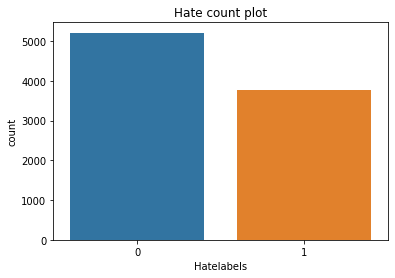

0    5213
1    3780
Name: Hatelabels, dtype: int64

In [5]:
# create countplot for Target column
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Hate count plot')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, "Hatelabels")
df["Hatelabels"].value_counts()

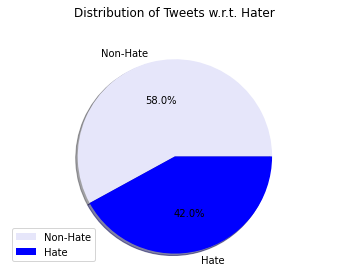

In [6]:
irony = [5213,3780]
colors_list = ['lavender', 'Blue']
my_labels = 'Non-Hate','Hate'
plt.pie(irony,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Distribution of Tweets w.r.t. Hater', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='lower left') 
plt.axis('equal')
plt.show()

######Mapping of Train Text Labels for Sentiment :  0 - Non Hate, 1 - Hate 



###Hashtag Word Cloud

(-0.5, 799.5, 499.5, -0.5)

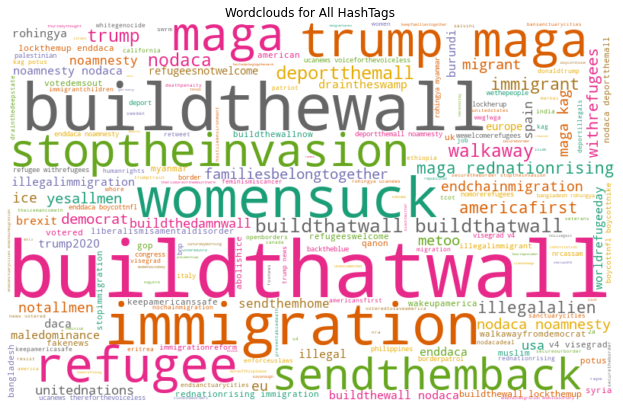

In [7]:
train_n=df
## Adding hashtags as separate column and plotting Wordcloud
train_n['Hashtags']=train_n.Tweet.apply(lambda x:','.join(re.findall("#[\w]*", x)))
train_n['Hashtags']=train_n['Hashtags'].apply(lambda x:re.sub("[#]*","",x))
train_n['Hashtags'] =train_n['Hashtags'].apply(lambda x:x.lower())
hastag=','.join(train_n['Hashtags'])
# generate wordcloud object
wordcloud=WordCloud( background_color="white", colormap="Dark2",width=800, height=500, random_state=21, max_font_size=110).generate(hastag)
# plot wordcloud
plt.figure(figsize=(14,7))
plt.title('Wordclouds for All HashTags ')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [8]:
df.head(2)

,Tweet,Hatelabels,Hashtags
0,@user nice new signage. Are you not concerned ...,0,
1,A woman who you fucked multiple times saying y...,1,


####Preprocessing Steps

#####Expand Contractions
#####Convert all text to lowercase
#####Remove Userhandles and Retweets
#####Remove html tags and urls 
#####Remove punctuation and digits
#####Remove stopword and lemmatization

####Contractions Expansion

In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Tweet']=df['Tweet'].apply(lambda x:expand_contractions(x))


In [10]:

import string
def clean_text(text):
    #convert the text to lower case
    text = text.lower()
    #remove @mention
    text = re.sub(r'@\w+', '', text)
    #remove Link word
    text = re.sub("{link}",'',text)
    #remove html tags
    text = re.sub("&[\w;]*",' ',text)
    #remove urls
    text = re.sub(r'http.?://[^\s]+[\s]?',' ',text)
    #remove RT
    text = re.sub(r'(?i)\bRT\b','',text)
    #remove content inside square brackets
    text = re.sub('\[.*?\]', ' ', text)
    #remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #remove digits
    text = re.sub('\d+', ' ',text)
    #remove new line character
    text= re.sub('\n', '', text)
    return text

In [11]:
df["Tweet"]= df.Tweet.apply(lambda x: clean_text(x))
df.Tweet.head(3)


0     nice new signage are you not concerned by bea...
1    a woman who you fucked multiple times saying y...
2      real talk do you have eyes or were they goug...
Name: Tweet, dtype: object

####Remove Emoji

In [12]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df["Tweet"]= df.Tweet.apply(lambda x: deEmojify(x))


####Remove Stopwords and Lemmatize

In [13]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['Lemmatized']=df['Tweet'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [14]:
df.head()

,Tweet,Hatelabels,Hashtags,Lemmatized
0,nice new signage are you not concerned by bea...,0,,nice new signage concern beatlemania style h...
1,a woman who you fucked multiple times saying y...,1,,woman fuck multiple time say yo dick small com...
2,real talk do you have eyes or were they goug...,1,,real talk eye gouge rapefugee
3,your girlfriend lookin at me like a groupie in...,1,,girlfriend lookin like groupie bitch
4,hysterical woman like,0,,hysterical woman like


In [15]:
# import nltk
# nltk.download('stopwords')
# def remove_stopwords(input_text):
#     stopwords_list = stopwords.words('english')
#     words = input_text.split()
#     clean_words = [word for word in words if (word not in stopwords_list ) and len(word) > 2] 
#     return " ".join(clean_words)

# df["cleaned"] = df.Tweet.apply(lambda x: remove_stopwords(x))

In [16]:
# import nltk
# nltk.download('punkt')
# from nltk import word_tokenize
# df["Tweet"] = [nltk.word_tokenize(x) for x in df["Tweet"]]
# df.head()


In [17]:
#For later use
df1=df[["Tweet","Hatelabels"]]


####Lemmatization

In [18]:
# nltk.download('wordnet')
# from nltk.corpus import wordnet
# from nltk.stem import WordNetLemmatizer
# def lemmatization(self,input_text):
#         words = input_text.split() 
#         lemma = WordNetLemmatizer()
#         lemma_words = [lemma.lemmatize(i) for i in words]
#         return " ".join(lemma_words)  
# df['Tweet'] = df['Tweet'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# df.head()

####Word Cloud for All words

(-0.5, 799.5, 499.5, -0.5)

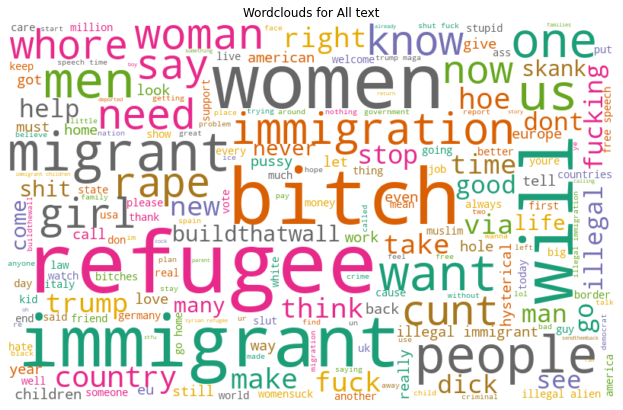

In [19]:
# Whole tweet wordcloud
all_words=' '.join(df['Tweet'])

# generate wordcloud object
wordcloud=WordCloud( background_color="white", colormap="Dark2",width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
# plot wordcloud
plt.figure(figsize=(15,7))
plt.title('Wordclouds for All text')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [20]:
label=[0,1]
new_data={}
for t in label:
    new_data[t]= ' '.join(df[df.Hatelabels.isin([t])].Lemmatized)
#new_data

In [21]:
#sentiment based DataFrame
train=pd.DataFrame(new_data.values(),index=new_data.keys(),columns=['Tweets'])
train.index=['Non-Hate','Hate'] 
overall_train=train.copy()
overall_train

,Tweets
Non-Hate,nice new signage concern beatlemania style h...
Hate,woman fuck multiple time say yo dick small com...


In [22]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(train.Tweets)
data_dtm = pd.DataFrame(data_cv.toarray(), index=train.index,columns=cv.get_feature_names())
data_stop=data_dtm.T


In [23]:
# # Find the top 30 Trending words in each sentiments
# top_dict = {}
# for c in data_stop.columns:
#     top = data_stop[c].sort_values(ascending=False).head(30)
#     top_dict[c]= list(zip(top.index, top.values))

# top_dict

In [24]:
# # Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
# from wordcloud import WordCloud
# from textwrap import wrap

# # Function for generating word clouds
# def generate_wordcloud(data,title):
#   wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
#   plt.figure(figsize=(7,5))
#   plt.imshow(wc, interpolation='bilinear')
#   plt.axis("off")
#   plt.title('\n'.join(wrap(title,60)),fontsize=13)
#   plt.show()
  
# # Transposing document term matrix
# data_stop

# # Plotting word cloud for each product
# for index,product in enumerate(data_stop.columns):
#   generate_wordcloud(data_stop[product].sort_values(ascending=False),product)

In [25]:
df.head()

,Tweet,Hatelabels,Hashtags,Lemmatized
0,nice new signage are you not concerned by bea...,0,,nice new signage concern beatlemania style h...
1,a woman who you fucked multiple times saying y...,1,,woman fuck multiple time say yo dick small com...
2,real talk do you have eyes or were they goug...,1,,real talk eye gouge rapefugee
3,your girlfriend lookin at me like a groupie in...,1,,girlfriend lookin like groupie bitch
4,hysterical woman like,0,,hysterical woman like


####Test Dataset

In [26]:
#Loading Test Dataset
df_test1 = pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_text.txt', header=None)
df_test1.head()
df_test1.columns
df_test1.count
print(df_test1.isnull().sum())
print(df_test1.shape)
df_test1=df_test1.rename(columns={0:"Tweet"})
df_test1.head()
df_test_labels=pd.read_fwf('https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/hate/test_labels.txt', header=None)
df_test_labels.head()
print(df_test_labels.shape)
df_test_labels=df_train_labels.rename(columns={0:"Hatelabels"})
df_test_labels.head()
dfs=[df_test1,df_test_labels]
df_test=pd.concat(dfs, axis=1, join="inner")
dft=df_test
df_test.head()

0    0
dtype: int64
(2970, 1)
(2970, 1)


,Tweet,Hatelabels
0,"@user , you are correct that Reid certainly is...",0
1,Whoever just unfollowed me you a bitch,1
2,@user @user Those People Invaded Us!!! They DO...,1
3,"stop JUDGING bitches by there cover, jus cuz s...",1
4,how about i knock heads off and send them gift...,0


In [27]:
## Preprocessing in Test Data

##Contraction expansion test data


# Expanding Contractions in the reviews
df_test['Tweet']=df_test['Tweet'].apply(lambda x:expand_contractions(x))


# Cleaning tweet
df_test["Tweet"]= df_test.Tweet.apply(lambda x: clean_text(x))



##SVM Classification

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report
X = df['Tweet']
X1 = df_test['Tweet']
y = df.Hatelabels
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

X = Xt
y = df.Hatelabels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print('SVM')
print('---------------------')
print(classification_report(y_test, y_pred))
print('')


SVM
---------------------
              precision    recall  f1-score   support

           0       0.60      0.77      0.67      1055
           1       0.44      0.25      0.32       744

    accuracy                           0.56      1799
   macro avg       0.52      0.51      0.50      1799
weighted avg       0.53      0.56      0.53      1799




##SVM Classification Test

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.svm import SVC  
from sklearn.metrics import classification_report
X1 = df_test['Tweet']
y = df_test.Hatelabels
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X1)

X = Xt
y = df_test.Hatelabels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print('SVM')
print('---------------------')
print(classification_report(y_test, y_pred))
print('')


SVM
---------------------
              precision    recall  f1-score   support

           0       0.56      0.81      0.66       332
           1       0.44      0.19      0.27       262

    accuracy                           0.54       594
   macro avg       0.50      0.50      0.46       594
weighted avg       0.51      0.54      0.49       594


